In [1]:
import sys
work_path = "/home/haselab/Documents/tat/Research/"
sys.path.append(f"{work_path}app/torch_libs/")

from run_manager import RunManager, RunsManager, RunViewer


In [25]:
import polars as pl
import matplotlib.pyplot as plt

rv = RunViewer(exp_path="/home/haselab/Documents/tat/Research/app/ee/exp_fil_data")
rv.write_stats()

df_stats = rv.fetch_stats()
df_stats_ext = df_stats.filter((pl.col("run_id") == 2))
run_ids = df_stats_ext["run_id"]

df_mets = rv.fetch_metrics()
df_agg = df_mets.group_by(by="run_id", maintain_order=True).agg(pl.all())
df_agg = df_agg.filter((pl.col("run_id").is_in(run_ids)))

display(df_agg)

run_id,step,lr,epoch,train_loss,train_acc,val_loss,val_acc
i32,list[i64],list[f64],list[i64],list[f64],list[f64],list[f64],list[f64]
2,"[1, 2, … 100]","[0.005, 0.004999, … 0.000001]","[1, 2, … 100]","[0.08403, 0.071941, … 0.033805]","[0.3431, 0.44724, … 0.74944]","[0.075028, 0.068612, … 0.031281]","[0.4204, 0.4779, … 0.7735]"


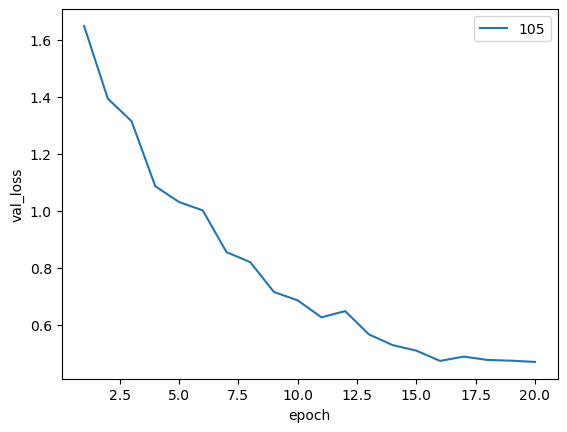

In [3]:
import polars as pl
import matplotlib.pyplot as plt

rv = RunViewer(exp_path="/home/haselab/Documents/tat/Research/app/ee/exp_tmp")
rv.write_stats()

df_stats = rv.fetch_stats()
# df_stats_ext = df_stats.filter((pl.col("fils") == 1) & (pl.col("num_data") == 10000))
df_stats_ext = df_stats
# df_stats_ext = df_stats.filter((pl.col("run_id") == 2))

run_ids = df_stats_ext["run_id"]
df_mets = rv.fetch_metrics()
df_agg = df_mets.group_by(by="run_id", maintain_order=True).agg(pl.all())
df_agg = df_agg.filter((pl.col("run_id").is_in(run_ids)))

x_col = "epoch"
y_cols = ["val_loss"]
label_col = "run_id"

fig, ax = plt.subplots(nrows=1, ncols=1, squeeze=False)
ax[0][0].set_xlabel(x_col)

for y_col in y_cols:
    ax[0][0].set_ylabel(y_col)
    for df_row in df_agg.iter_rows(named=True):
        x = pl.Series(df_row[x_col])
        y = pl.Series(df_row[y_col]).rolling_mean(window_size=1, min_periods=0)
        label = df_stats.filter(pl.col("run_id") == df_row["run_id"])[label_col][0]

    ax[0][0].plot(x, y, label=label)

ax[0][0].legend()





In [35]:
def rv_to_figs(rv, row_name, col_name, x_col, y_col, label_col, window_size=None):
    df_stats = rv.fetch_stats()
    df_mets = rv.fetch_metrics()

    row_vals = df_stats[row_name].unique()
    col_vals = df_stats[col_name].unique()

    fig, ax = plt.subplots(nrows=len(row_vals), ncols=len(col_vals), squeeze=False)
    plt.subplots_adjust(hspace=0.3)
    fig.set_figwidth(6 * len(row_vals))
    fig.set_figheight(4 * len(col_vals))

    for r, row_val in enumerate(row_vals):
        for c, col_val in enumerate(col_vals):

            df_stats_ext = df_stats.filter((pl.col(row_name) == row_val) & (pl.col(col_name) == col_val))
            run_ids = df_stats_ext["run_id"]

            df_agg = df_mets.group_by(by="run_id", maintain_order=True).agg(pl.all())
            df_agg = df_agg.filter((pl.col("run_id").is_in(run_ids)))

            ax[r][c].set_xlabel(x_col)
            ax[r][c].set_ylabel(y_col)
            ax[r][c].set_title(f"{row_name}: {row_val}, {col_name}: {col_val}")

            for df_row in df_agg.iter_rows(named=True):
                x = pl.Series(df_row[x_col])
                y = pl.Series(df_row[y_col]).rolling_mean(window_size=window_size, min_periods=0)
                # label = df_stats.filter(pl.col("run_id") == df_row["run_id"])[label_col][0]
                # ax[r][c].plot(x, y, label=label)
                ax[r][c].plot(x, y)
            # ax[r][c].legend()




rv = RunViewer(exp_path="/home/haselab/Documents/tat/Research/app/ee/exp_fil_data")
rv_to_figs(rv, "fils", "num_data", "epoch", "val_acc", "num_data", window_size=4)


KeyboardInterrupt: 

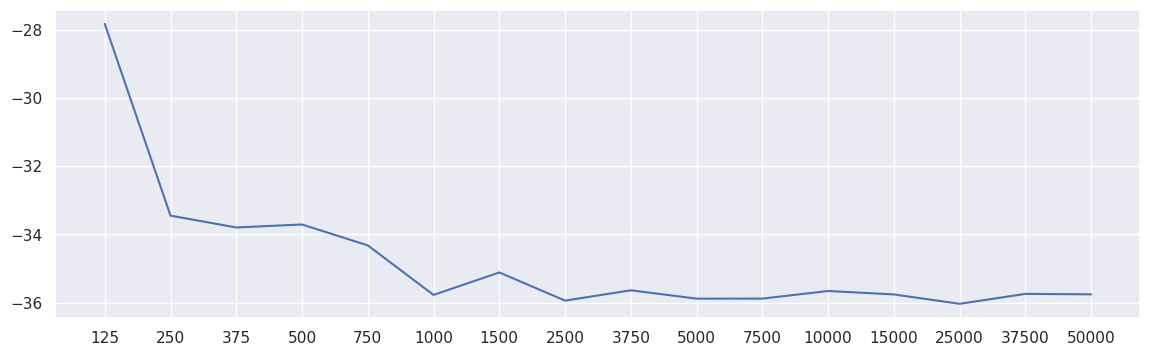

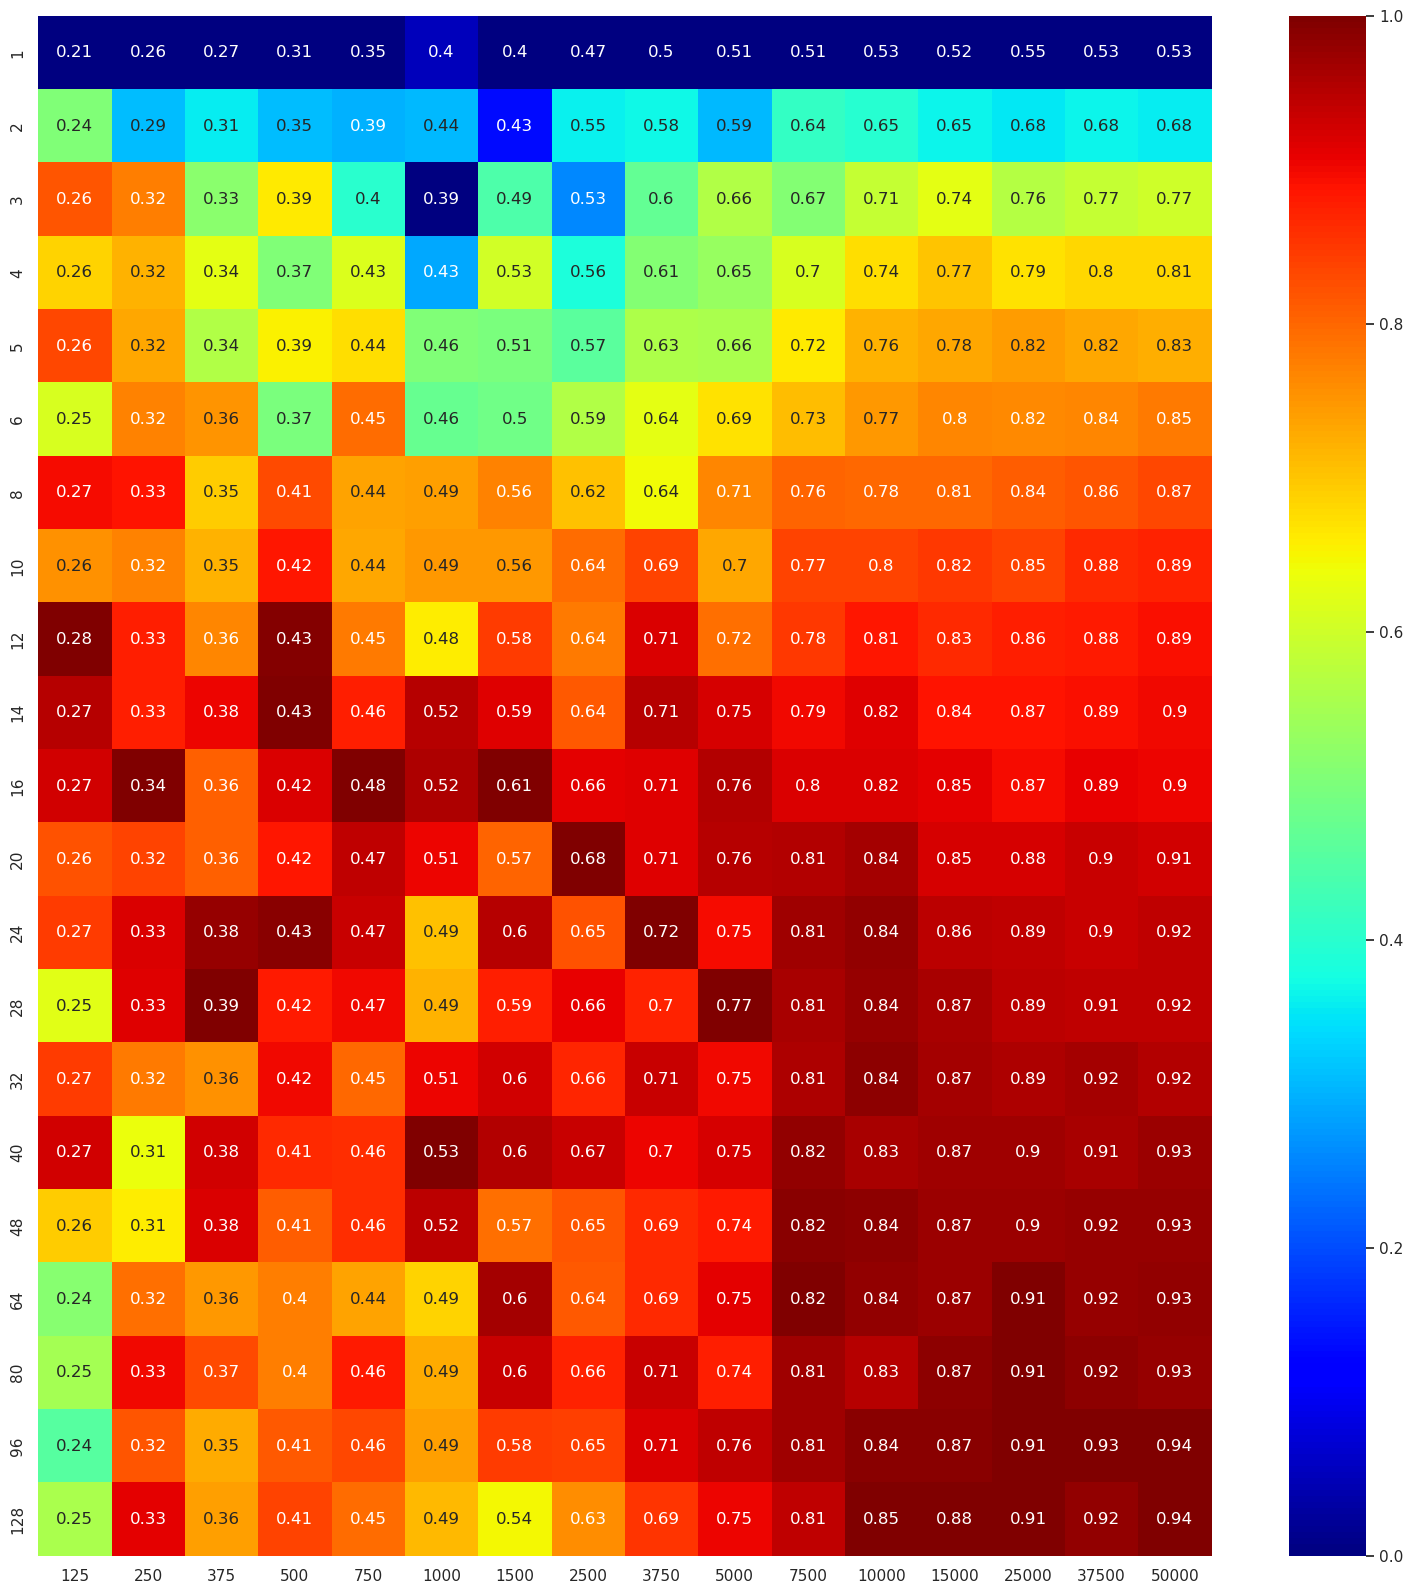

In [ ]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def heat_pivot(df, values, index, columns, aggregate_function=None, cmap=None, annot_rescale=False, color_rescale=False):
    df = df.pivot(values=values, index=index, columns=columns, aggregate_function=aggregate_function)
    # df = df.reverse()
    df = df.select(df.columns[::-1])
    df_ind_ser= df.select(index).to_series()
    df = df.select(pl.all().exclude(index))

    xlabels = df.columns
    ylabels = df_ind_ser
    
    def rescale(df):
        for col_name in df.columns:
            col_ser = df[col_name]
            max_val = col_ser.max()
            min_val = col_ser.min()

            df = df.with_columns(pl.col(col_name).sub(min_val).truediv(max_val - min_val))
        return df

    re_df = rescale(df)
    

    def col_prop(df):
        for col_name in df.columns:
            col_ser = df[col_name]
            sum_val = col_ser.sum()

            df = df.with_columns(pl.col(col_name).truediv(sum_val))
        return df

    prop_df = col_prop(re_df)

    prop_df = (prop_df * df_ind_ser).sum()
    
    # prop_df.write_csv("./prop.csv")
    tmp = prop_df.row(0)
    tmp2 = []
    for t in tmp: tmp2.append(t*-1)
    plt.figure(figsize=(14, 4))
    plt.plot(prop_df.columns, tmp2)
    plt.show()
    

    if annot_rescale: annot_C = re_df.to_numpy()
    else: annot_C = df.to_numpy()

    if color_rescale: color_C = re_df.to_numpy()
    else: color_C = df.to_numpy()

    
    sns.set(rc={"figure.figsize": (20, 20)})
    sns.heatmap(color_C, annot=annot_C, cbar=True, square=True, cmap=cmap, xticklabels=xlabels, yticklabels=ylabels)
    plt.show()


df = df_stats
heat_pivot(df, values="val_acc", index="fils", columns="num_data", cmap="jet", aggregate_function="mean", annot_rescale=False, color_rescale=True)


